In [29]:
from random import random
from sage.plot.histogram import Histogram

In [6]:
standard_basis = lambda space, n : [vector(space, [int(i==j) for j in range(n)]) for i in range(n)]
normalize = lambda vector: vector/norm(vector)
normalize_list = lambda vector_list : [normalize(x) for x in vector_list]

## some good functions

# gets you the frame coefficients for a vector
analysis_operator = lambda vector, frame : [vector.dot_product(i) for i in frame]
# gets you the vector from frame coefficients
synthesis_operator = lambda coefficients, frame: sum([coefficients[i]*frame[i] for i in range(len(frame)) if len(frame) == len(coefficients)])

In [12]:
# Let {e1, e2, .... ,en} be the standard orthonormal basis for R^n
# Then this function generates the frame { e1/sqrt(split), e2/sqrt(split), .... ,e3/sqrt(split) }
# This frame will have dimension*split no. of elements in it

def gen_frame1(space=RR, dimension=3, split=2):
    basis = standard_basis(space, dimension)
    frame = [x/sqrt(split) for x in basis for i in range(split)]
    return frame

In [13]:
# Let {e1, e2, .... ,en} be the standard orthonormal basis for R^n
# Then this function generates the frame {e1, e2, .... ,en} on the first iteration
# and {e1, ... , en, e1+e2, e2+e3, ...,en+e1} on its second iteration
# and {e1, ... , en, e1+e2, e2+e3, ...,en+e1, e1+e2+e3, ..., en+e1+e2} on it's 3rd iteration
# and so on at m-th iteration it'll have n*(2^m) elements
# Note also that all vectors will be normalilzed in the end to unit vectors

def gen_frame2(space=RR, dimension=3, iterations=2):
    basis = standard_basis(space, dimension)
    frame = basis.copy()
    
    flag = False
    if iterations >= dimension:
        iterations = dimension-1
        flag = True
    
    # generates e1+e2, ..., en+e1
    for i in range(1, iterations): #eliminates first iteration and gives back frame itself
        
        # generates each n-summand
        for j in range(len(basis)): #start postition of the ordered basis vector
            temp_vectors = [] # store the first n vectors from the start position
            #get the first n vectors from start position
            for k in range(j, i+1+j): #the step size should be atleast 2
                temp_vectors.append(basis[k%len(basis)]) # put the vectors into temp_vectors
            frame.append(sum(temp_vectors)) # add the summand to temp_frame
    if flag :
        frame.append(sum(basis))
    return normalize_list(frame)

In [14]:
# Let {e1, e2, .... ,en} be the standard orthonormal basis for R^n
# Then this function generates the frame {e1, e2, .... ,en} on the first iteration
# and {e1, ... , en, -(e1+e2), -(e2+e3), ...,-(en+e1)} on its second iteration
# and {e1, ... , en, -(e1+e2), -(e2+e3), ...,-(en+e1), e1+e2+e3, ..., en+e1+e2} on it's 3rd iteration
# and so on at m-th iteration it'll have n*(2^m) elements
# Note also that all vectors will be normalilzed in the end to unit vectors

def gen_frame2_1(space=RR, dimension=3, iterations=2):
    basis = standard_basis(space, dimension)
    frame = basis.copy()
    
    flag = False
    if iterations >= dimension:
        iterations = dimension-1
        flag = True
    
    # generates e1+e2, ..., en+e1
    for i in range(1, iterations): #eliminates first iteration and gives back frame itself
        
        # generates each n-summand
        for j in range(len(basis)): #start postition of the ordered basis vector
            temp_vectors = [] # store the first n vectors from the start position
            #get the first n vectors from start position
            for k in range(j, i+1+j): #the step size should be atleast 2
                temp_vectors.append(basis[k%len(basis)]) # put the vectors into temp_vectors
            frame.append((-1)**(i)*sum(temp_vectors)) # add the summand to temp_frame
    if flag :
        frame.append((-1)**(iterations)*sum(basis))
    return normalize_list(frame)

In [19]:
def frame_analysis(frame, space=QQ, min_loss=1, max_loss=1, norm_bound=100, iterations=100, verbose=True):
    
    # some good constants
    space_dimension = len(frame[0])
    frame_length = len(frame)
    er_max, er_min = 0, space_dimension*norm_bound
    
    # ouput variables
    inp = []
    out = []
    err = []
    
    # Let's start analysis
    for i in range(iterations):
        
        # Picking a random vector within the bound
        while True:
            v = vector(space, [uniform(-1*norm_bound, norm_bound) for i in range(space_dimension)])
            if norm(v) <= norm_bound:
                inp.append(v)
                break
        
        # Get me frame co-efficients of the vector
        frame_coeffs = analysis_operator(v, frame)
        
        # Emulating recieved_vector after signal loss in frame_coefficients
        recieved_frame_coeffs = frame_coeffs
        count_losing_coordinates = randint(min_loss, min(max_loss, frame_length))
        lost_coordinates = []
        for i in range(count_losing_coordinates):
            while True:
                losing_coordinate = randint(0, frame_length-1)
                if losing_coordinate not in lost_coordinates:
                    lost_coordinates.append(losing_coordinate)
                    break
            recieved_frame_coeffs[losing_coordinate] = 0
            
        # recieved vector after transmission loss
        u = synthesis_operator(recieved_frame_coeffs, frame)
        out.append(u)
        
        # transmission error
        error = norm(v-u)
        err.append(error)
        if error > er_max:
            er_max = error
        if error < er_min:
            er_min = error
        if verbose:
            print("Transmission error is :", error)
        
    print("Analysis Completed")
    print("Iterations:", iterations)
    print("Maximum Error:", er_max)
    print("Minimum Error:", er_min)
    
    return {"input":inp, "output":out, "error":err}

In [37]:
%%time
frame = gen_frame1(space=RR, dimension=3, split=2)
print("Size of selected frame:", len(frame))
result = frame_analysis(frame, space=RR, min_loss=1, max_loss=3, norm_bound=100, iterations=10000, verbose=False)
error = list(map(round, result["error"]))
error.sort()
domain = [i for i in range(min(error), max(error)+1)]
count = [error.count(i) for i in domain]
p1 = points([(domain[i], count[i]) for i in range(min(error), max(error)+1)], rgbcolor='red', legend_label='1st frame')

Size of selected frame: 6
Analysis Completed
Iterations: 10000
Maximum Error: 98.9139011139096
Minimum Error: 0.00710132635652627
CPU times: user 9.02 s, sys: 7.82 ms, total: 9.03 s
Wall time: 9.03 s


In [38]:
%%time
frame = gen_frame2(space=RR, dimension=3, iterations=2)
print("Size of selected frame:", len(frame))
result = frame_analysis(frame, space=RR, min_loss=1, max_loss=3, norm_bound=100, iterations=10000, verbose=False)
error = list(map(round, result["error"]))
error.sort()
domain = [i for i in range(min(error), max(error)+1)]
count = [error.count(i) for i in domain]
p2 = points([(domain[i], count[i]) for i in range(min(error), max(error)+1)], color="blue", legend_label="2nd frame")

Size of selected frame: 6
Analysis Completed
Iterations: 10000
Maximum Error: 175.112751995289
Minimum Error: 0.000000000000000
CPU times: user 2.28 s, sys: 3.98 ms, total: 2.28 s
Wall time: 2.28 s


In [39]:
%%time
frame = gen_frame2_1(space=RR, dimension=3, iterations=2)
print("Size of selected frame:", len(frame))
result = frame_analysis(frame, space=RR, min_loss=1, max_loss=3, norm_bound=100, iterations=10000, verbose=False)
error = list(map(round, result["error"]))
error.sort()
domain = [i for i in range(min(error), max(error)+1)]
count = [error.count(i) for i in domain]
p3 = points([(domain[i], count[i]) for i in range(min(error), max(error)+1)], color="green", legend_label="3rd frame")

Size of selected frame: 6
Analysis Completed
Iterations: 10000
Maximum Error: 174.900847370308
Minimum Error: 0.000000000000000
CPU times: user 2.38 s, sys: 0 ns, total: 2.38 s
Wall time: 2.38 s


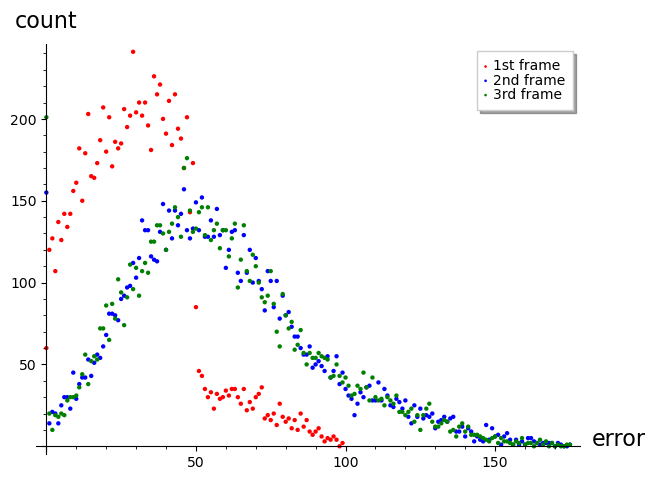

In [42]:
errorplot = p1+p2+p3
errorplot.show(axes_labels=["error", 'count'])